In [1]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import LinearRing, Polygon
from geopandas import GeoDataFrame
from geopandas import GeoSeries
import os
import math
import numpy as np 
from shapely import affinity

# QUESTÃO A SER RESPONDIDA

DADO QUE as primeiras observaçoes de esporos ocorreram nos coletores x,y,z no dia dd/mm/aa      
PERGUNTA-SE, após quantos dias um coletor w detectará esporos depois da detecção inicial?

# ABORDAGEM

Supomos que a sequência temporal de detecções englobe, em alguma medida, o regime de ventos e o relevo da região.

## Grafo de Propagação

A partir dos dados da primeira observação nos diversos coletores, é criado um grafo G=(V,E), tal que, V são os coletores;
(u,v) $\in$ E, se foram detectados esporos primeiro no coletor u e depois no coletor v. Este grafo tende a ser bastante denso. Por isso, também são definidos alguns critérios de poda de arestas.

## Estratégia 1: Buffer Seminal

O grafo de propagação é, a seguir, usado para criar um buffer inicial (buffer seminal) para cada estação.
Dada uma observação inicial, vamos crescer o buffer seminal da estação que detectou a observação inicial e, assim, produzir o mapa de crescimento. Ao final do crescimento

<img src="exemplo-1-buffer-seminal.svg" style="width: 100px">

## Estratégia 2: Geometria do Crescimento

Esta estratégia é uma generalização do buffer seminal. Calculamos e guardamos os mesmos pontos de referência, mas não definimos uma região (buffer) que será incrementalmente expandido. Em vez vez disso, "crescemos" os pontos de referência e, só posteriormente, é criada uma região correspondente à geometria corrente

<img src="exemplo-geometria-crescimento.svg" style="width: 600px">


# CONSTRUÇÃO DA MATRIZ DE ADJACÊNCIA

# Construção do Grafo

## Pré-processamento (constroiMatriz)

- Vamos usar uma matriz de adjacência
- Cada coletor é um nó
- O data frame gdf é processado e a matriz é atualizada
- i significa que a corrente invocação é a i-esima invocação, o seja, o peso de uma aresta (u,v) é a média de (i-1) iteracoes

In [2]:
def calcularDistanciaEntreColetores(geo_df):
    distancias = pd.DataFrame(00.0,index=geo_df.index,columns=geo_df.index)  # TODO
    for i in geo_df.index:
        for j in geo_df.index:
            p1 = geo_df.loc[i].geometry
            p2 = geo_df.loc[j].geometry
            distancias.at[i,j] = p1.distance(p2)
    return distancias

def deltaTempo(gdf,i,j):
    row_i = gdf.iloc[i]
    dia_i = row_i['Dias_apos_O0'] 
    row_j = gdf.iloc[j]
    dia_j = row_j['Dias_apos_O0']
    delta_t = dia_j - dia_i
    return delta_t
    
def calculaVelocidade(gdf,i,j,distancias,delta_t):
    
    distancia_i_j = distancias.at[gdf.index[i],gdf.index[j]]
    veloc = 0.0 if delta_t == 0 else distancia_i_j / delta_t
    
    return veloc

def atualizaVelocidadeMedia(matrizAdj,i,j, k, index, veloc):
    mediaAntiga = matrizAdj.at[index[i],index[j]]
    mediaNova = (mediaAntiga*(k-1) + veloc) / k
    matrizAdj.at[index[i],index[j]] = mediaNova
    
def constroiMatriz(matrizAdj, k: int, geo_df: GeoDataFrame, distancias,max_delta_t=10):
    gdf = geo_df.query('Dias_apos_O0 > 0').sort_values('Dias_apos_O0')
    nrows = len(gdf.index)
    for i in range(nrows): 
        for j in range(i+1,nrows):
            dt = deltaTempo(geo_df,i,j)
            if ( dt <= max_delta_t):
                #print("i: ", i, "  j: ", j , "  index[i]: ", gdf.index[i], "   index[j]: ", gdf.index[j])
                veloc = calculaVelocidade(gdf,i,j,distancias,dt)
                #print("veloc: ", veloc);                                                                                
                atualizaVelocidadeMedia(matrizAdj,i,j, k, gdf.index, veloc)
    return matrizAdj
    
def _printMatriz(ma,gdf):
    nrows = len(gdf.index)
    
    print("00\t",end="")
    for i in range(nrows):
        if i % 10 == 0:
            print("|",end="")
        else:
            print(".",end="")
    print("")
        
    for i in range(nrows): 
        print("")
        print(i,"\t",end="")
        for j in range(nrows):
            if ma.at[i,j] > 0:
                print("X",sep=" ",end="")
            else:
                print("-",sep=" ",end="")
            
    

# CONSTRUÇÃO DO GRAFO


# Construção do Grafo
Vamos construir um grafo G = (V,E)

## Vértices
V = cjto dos coletores

**Atributos de um vértice:**
- *td*: tempo de detecção (em relação à primeira detecção)

## Arestas

- (u,v) $\in$ E, se foram detectados esporos em u e v, u.td < v.td
- para diminuir a densidade do grafo, acrescentei a condição: v.td - u.td <= max_delta_t


** Atributos de uma aresta**
- *v*: velocidade de propagação. Velocidade de propagação mínima para que os esporos detectados em u sejam dissiminados até v. (distancia(v,u)/(v.td - u.td))

# Hipótese

O caminho de propagação deve seguir o caminho *"mais lento"*

# Qual pacote de grafos usar?

Estou analizando:

- https://easy-graph.github.io/
- https://networkx.org/ : escolhi este
- https://graph-tool.skewed.de/: este pareceu-me interessante, mas é mantido por uma única pessoa

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString

def constroiGrafo(matrizAdj, geo_df, distancias, rpc: float):
    G = nx.DiGraph()
    G.add_nodes_from(matrizAdj.index)
    for i in matrizAdj.index:
        posicaoColetor = geo_df.loc[i].geometry
        G.nodes[i]['local'] = posicaoColetor
        G.nodes[i]['idx'] = i
        for j in matrizAdj.index:
            w = matrizAdj.at[i,j]
            distancia = distancias.at[i,j]
            if (w > 0.0) and (distancia <= rpc):  # "poda" arestas muito longas
                G.add_edge(i,j,weight=w)
    return G
                
    
def printPath(gdf,path):
    linestring = []
    for p in path:
        pto = gdf.loc[p]
        linestring.append(pto['geometry'])
    return LineString(linestring)

def coordinatesGeometry(gdf,path):
    xs= []
    ys = []
    for p in path:
        pto = gdf.loc[p]
        xs.append(pto['geometry'].x)
        ys.append(pto['geometry'].y)
    return (xs,ys)

# Coletores


In [4]:
class Coletores:
    def __init__(self,coletoresfn, nomeCampoLongitude: str , nomeCampoLatitude: str, nomeCampoDiasAposO0: str, 
                 nomeCampoDataObs: str):
        self.Longitude = nomeCampoLongitude
        self.Latitude = nomeCampoLatitude
        self.DiasAposO0 = nomeCampoDiasAposO0
        self.Data = nomeCampoDataObs
        self.geo_df = self._readColetores(coletoresfn,nomeCampoLongitude, nomeCampoLatitude, nomeCampoDiasAposO0, nomeCampoDataObs,False)
        self.grafoPropagacao = None
      
    def addColetores(self, coletoresfn, nomeCampoLongitude: str="" , nomeCampoLatitude: str = "", 
                     nomeCampoDiasAposO0: str="", nomeCampoDataObs: str = "",fake = False):
        new_gdf = self._readColetores(coletoresfn, nomeCampoLongitude, nomeCampoLatitude, nomeCampoDiasAposO0, 
                                 nomeCampoDataObs, fake)
        self.geo_df.append(new_gdf)
    
    def preencheComColetoresFake(self):
        pass
    
    def _readColetores(self, coletoresfn, nomeCampoLongitude: str , nomeCampoLatitude: str, nomeCampoDiasAposO0: str, 
                       nomeCampoDataObs: str, fake):
        df = pd.read_csv(coletoresfn, sep=';', decimal=',', parse_dates=[self.Data], infer_datetime_format=True).sort_values(by='Data')
        geometry = [Point(x,y) for x,y in zip(df[self.Longitude], df[self.Latitude])]
        new_gdf = GeoDataFrame(df, geometry=geometry)
        new_gdf['fake'] = new_gdf.apply(lambda x: fake)
        
        if nomeCampoLongitude != "":
            new_gdf.rename(columns={nomeCampoLongitude: self.Longitude}, inplace = True)   
        if nomeCampoLatitude != "":
            new_gdf.rename(columns={nomeCampoLatitude: self.Latitude}, inplace = True)   
        if nomeCampoDiasAposO0 != "":
            new_gdf.rename(columns={nomeCampoDiasAposO0: self.DiasAposO0}, inplace = True)   
        if nomeCampoLongitude != "":
            new_gdf.rename(columns={nomeCampoDataObs: self.Data}, inplace = True)   
                                                 
        return new_gdf
                                                 
    def criaGrafo(self,rpc, max_delta_t = 20):
        matrizAdjacencia = pd.DataFrame(0.0,index=self.geo_df.index, columns=self.geo_df.index)
        distancias = calcularDistanciaEntreColetores(self.geo_df)
        matrizAdjacencia = constroiMatriz(matrizAdjacencia, 1, self.geo_df, distancias,max_delta_t)
        G = constroiGrafo(matrizAdjacencia,self.geo_df, distancias, rpc)
        self.grafoPropagacao = G
        self._distancias = distancias  
                            
    def geraGeometriasCrescimento(self,rai, rpc):
        G = self.grafoPropagacao
                                                 
        idx = [ ]
        ggs = [ ]
    
        for nodeColetor, coletoresVizinhos in G.adj.items():
            #print("coletor: ", nodeColetor, "   coletores vizinhos: ", coletoresVizinhos)
            localColetor = G.nodes[nodeColetor]['local']
            indiceColetor = G.nodes[nodeColetor]['idx']
            gg = GrowthGeometry(localColetor, rai)
            for coletorVizinho, arestaColetorParaVizinho in coletoresVizinhos.items():
                localColetorVizinho = G.nodes[coletorVizinho]['local']
                (p1,p2) = calculaSegmentoGeometria(localColetor,localColetorVizinho,rai,rpc)
                gg.addSegment(p1,p2)
                #print(bufferCorrente.boundary)
            idx.append(indiceColetor)
            ggs.append(gg)
        
        return (ggs,idx)
                                               
        
    

In [5]:
##
## REMOVER
##

def preparaDadosIniciais(coletoresfn,nomeCampoLongitude = "LongitudeDecimal", nomeCampoLatitude="LatitudeDecimal"):
    df = pd.read_csv(coletoresfn, sep=';', decimal=',', parse_dates=['Data'], infer_datetime_format=True).sort_values(by='Data')
    geometry = [Point(x,y) for x,y in zip(df.LongitudeDecimal, df.LatitudeDecimal)]
    geo_df = GeoDataFrame(df, geometry=geometry)
    return geo_df

def criaGrafo(geo_df, rpc, max_delta_t = 20):
    matrizAdjacencia = pd.DataFrame(0.0,index=geo_df.index, columns=geo_df.index)
    distancias = calcularDistanciaEntreColetores(geo_df)
    matrizAdjacencia = constroiMatriz(matrizAdjacencia, 1, geo_df, distancias,max_delta_t)
    G = constroiGrafo(matrizAdjacencia,geo_df, distancias, rpc)
    return (G,distancias)

# CONSTRUÇÃO DO BUFFER SEMINAL

## Buffer Seminal

Considere o grafo de propagação G construído anteriormente.
Vamos definir duas medidas: (a) área de abrangência imediata da estação (AI); (b) área de potencial contaminação direta (APC).

## Área de Abrangência Imediata (AI)

É definida por uma circunferência de raio rai, centrada na estação de monitoramento. Esta circunferência será distorcida a fim de gerar o buffer seminal da estação.

## Área de Potencial Contaminação Direta (APC)

É definida por uma circunferência de raio rpc, centrada na estação de monitoramento. Define um critério de "poda" de arestas
do grafo G: arestas de comprimento superior a rpc são desconsideradas.

## Algoritmo 

```
 para cada vértice v do grafo G
    bufferCorrente = Circunferência de raio rai com centro no local do coletor v
    para cada aresta (v,u) de G
        se distancia dos coletores v e u menor que rpc então
            Adicione ao bufferCorrente uma pequena "expansão" na direção do coletor u
        fim se
    fim para
    buffers[u] = bufferCorrente
 fim para
```

<img src="seminal.svg" style="width: 600px">



In [6]:
##
## REMOVER
##


# constroi um triangulo "apontando" na direcao do coletor vizinho
def calculaBufferExpansao(localColetor: Point, localColetorVizinho: Point, rai: float, rpc: float):
    arc = LineString([localColetor,localColetorVizinho])
    
    segmentoA = affinity.rotate(arc, 90, origin=localColetor)
    segmentoB = affinity.rotate(arc, -90, origin=localColetor)
    b1 = segmentoA.interpolate(rai);
    b2 = segmentoB.interpolate(rai);
    
    proporcao = arc.length / rpc  # < 1, pois aresta mais extensas que rpc foram "podadas" anteriormente
    dt = rai + rai * proporcao
    p = arc.interpolate(dt)
    
    trianguloExpansao = Polygon([p, b1, b2])
    bufferExpansao = trianguloExpansao.buffer(0.00001)
    return bufferExpansao

def calculaSegmentoGeometria(localColetor: Point, localColetorVizinho: Point, rai: float, rpc: float):
    arc = LineString([localColetor,localColetorVizinho])
    
    segmentoA = affinity.rotate(arc, 90, origin=localColetor)
    segmentoB = affinity.rotate(arc, -90, origin=localColetor)
    b1 = segmentoA.interpolate(rai);
    b2 = segmentoB.interpolate(rai);
    
    proporcao = arc.length / rpc  # < 1, pois aresta mais extensas que rpc foram "podadas" anteriormente
    dt = rai + rai * proporcao
    p = arc.interpolate(dt)
    
    return (p , localColetorVizinho)
    
    
def geraBufferSeminal(geo_df, rai, rpc, G, distancias):
    idx = [ ]
    bufs = [ ]
    #print(G.nodes.data())
    for nodeColetor, coletoresVizinhos in G.adj.items():
        #print("coletor: ", nodeColetor, "   coletores vizinhos: ", coletoresVizinhos)
        localColetor = G.nodes[nodeColetor]['local']
        indiceColetor = G.nodes[nodeColetor]['idx']
        bufferCorrente = localColetor.buffer(rai)
        for coletorVizinho, arestaColetorParaVizinho in coletoresVizinhos.items():
            localColetorVizinho = G.nodes[coletorVizinho]['local']
            bufferExpansao = calculaBufferExpansao(localColetor,localColetorVizinho,rai,rpc)
            bufferCorrente = bufferCorrente.union(bufferExpansao)
            #print(bufferCorrente.boundary)
        idx.append(indiceColetor)
        bufs.append(bufferCorrente)
        
    bufs_gs = GeoSeries(bufs,idx)
    return bufs_gs

def geraGeometriasCrescimento(geo_df, rai, rpc, G, distancias):
    idx = [ ]
    ggs = [ ]
    #print(G.nodes.data())
    for nodeColetor, coletoresVizinhos in G.adj.items():
        #print("coletor: ", nodeColetor, "   coletores vizinhos: ", coletoresVizinhos)
        localColetor = G.nodes[nodeColetor]['local']
        indiceColetor = G.nodes[nodeColetor]['idx']
        gg = GrowthGeometry(localColetor, rai)
        for coletorVizinho, arestaColetorParaVizinho in coletoresVizinhos.items():
            localColetorVizinho = G.nodes[coletorVizinho]['local']
            (p1,p2) = calculaSegmentoGeometria(localColetor,localColetorVizinho,rai,rpc)
            gg.addSegment(p1,p2)
            #print(bufferCorrente.boundary)
        idx.append(indiceColetor)
        ggs.append(gg)
        
    return (ggs,idx)

    

# GEOMETRIA DE CRESCIMENTO

Para cada coletor é criada uma "geometria de crescimento". 
Esta geometria é constituída pelas coordenadas do coletor (center), pelo raio de abrangência imediata (rai) e um conjunto de segmentos, como apresentado anteriormente. A cada segmento também é associado um ponto máximo de crescimento que corresponde às coordenadas do coletor adjacente.

<img src="esqueleto-crescimento.svg" style="width: 600px">

In [7]:
class GrowthGeometry:
    def __init__(self, center: Point, rai: float):
        self.center = center
        self.r = rai
        self._segs = []
        
    def addSegment(self, p: Point, pMax: Point):
        # todos segmentos tem origem no ponto central
        # ponto central deve ser sempre a primeira coordenada
        segm = LineString([self.center,p, pMax])
        self._segs.append(segm)
        
    def growGeometry(self, proportion: float):
        grownSegs = []
        for _ in range(len(self._segs)):
            seg = self._segs.pop()
            center = Point(seg.coords[0])
            p1 = Point(seg.coords[1])
            dist = center.distance(p1)
            newLen = dist * proportion
            newP = seg.interpolate(newLen)
            newSeg = LineString([self.center,newP,seg.coords[2]])
            grownSegs.append(newSeg)
        self._segs.extend(grownSegs)
        
    def getSegments(self):
        return self._segs

## Criação de buffers a partir de uma geometria de crescimento

<img src="exemplo-buffer-michelin.svg" style="width: 600px">

In [8]:
# constroi um triangulo "apontando" na direcao do coletor vizinho
def calculaTrianguloExpansao(segm, r):
    arc = LineString([segm.coords[0],segm.coords[2]])
    
    segmentoA = affinity.rotate(arc, 90, origin=segm.coords[0])
    segmentoB = affinity.rotate(arc, -90, origin=segm.coords[0])
    b1 = segmentoA.interpolate(r);
    b2 = segmentoB.interpolate(r);
    
    trianguloExpansao = Polygon([segm.coords[1], b1, b2])
    bufferExpansao = trianguloExpansao.buffer(0.00001)
    return bufferExpansao

def criaCarrapicho(gg: GrowthGeometry, proportR: float):
    r = gg.r * proportR
    buffer = gg.center.buffer(r)
    segs = gg.getSegments()
    for seg in segs:
        bufferExpansao = calculaTrianguloExpansao(seg,r)
        buffer = buffer.union(bufferExpansao)  
    return buffer

def calculaBufferMembroBoneco(seg, r1,r2, npassos: int):
    p0 = Point(seg.coords[0])
    p1 = Point(seg.coords[1])
    distanciaEntreCentros = p0.distance(p1)
    dpasso = distanciaEntreCentros/npassos
    diffRaios = r1 - r2
    buffer = p1.buffer(r2)
    for i in range(1,npassos+1):
        di = i * dpasso
        dr = (diffRaios * di) / distanciaEntreCentros
        ri = r2 + dr
        distP0ci = distanciaEntreCentros - di
        ci = seg.interpolate(distP0ci)
        bufferI = ci.buffer(ri)
        buffer = buffer.union(bufferI)
    return buffer
        
    
def criaBonecoMichelin(gg: GrowthGeometry, r1: float, r2: float):
    segs = gg.getSegments()
    buffer = gg.center.buffer(r1)
    for seg in segs:
        p0 = Point(seg.coords[0])
        p1 = Point(seg.coords[1])
        d = p1.distance(p0)
        npassos = int(d / r2) + 1
        bufferExpansao = calculaBufferMembroBoneco(seg,r1,r2, npassos)
        buffer = buffer.union(bufferExpansao)  
    return buffer

def geraBuffersCarrapichos(geom_cresc, r: float):
    buffs = []
    for gg in geom_cresc:
        buf = criaCarrapicho(gg,r)
        buffs.append(buf)
    return buffs
        
def geraBuffersBonecosMichelin(geom_cresc, r1: float, r2: float):
    buffs = []
    for gg in geom_cresc:
        buf = criaBonecoMichelin(gg, r1, r2)
        buffs.append(buf)
    return buffs

# PLOTTING

In [9]:
def plotting(mapafn,bufs,titulo,fn=None):
    _map = geopandas.read_file(mapafn) 
    base = _map.plot(color='lightgrey', edgecolor='whitesmoke')

    plt.title('Ferrugem asiática no Paraná'+titulo, fontsize=20)
    plt.xlabel('Longitude', fontsize=15)
    plt.ylabel('Latitude', fontsize=15)
    bufs.plot(ax=base)
    if fn is not None:
        plt.savefig(fn)
    
def plotting2(mapafn,coords,fn, titulo):
    # plot
    #fig, ax = plt.subplots()
    
    _map = geopandas.read_file(mapafn) 
    base = _map.plot(color='lightgrey', edgecolor='whitesmoke')

    plt.title(titulo)
    plt.xlabel('Longitude', fontsize=15)
    plt.ylabel('Latitude', fontsize=15)
    plt.plot(ax=base)
    plt.plot(coords[0], coords[1], linewidth=2.0)
    plt.savefig(fn)

def plotGrafo(geo_df,G):
    aux = geo_df['geometry']
    coordinates = np.column_stack((aux.geometry.x, aux.geometry.y))
    positions = dict(zip(aux.index, coordinates))
    nx.draw(G, positions,with_labels=True)

In [10]:
def main(mapaBasePath,coletoresfn,rpc,rai,fnbase="bf-"):
    #mapasDir='C:\\Users\\evand\\git\\movimentacao-esporos\\dados\\divisas_PR_shapefiles\\pr'
    #dataDir= "C:\\Users\\evand\\git\\movimentacao-esporos\\dados\\safra2021"
    bufsSemFnc = os.path.join(dataDir,fnbase+"mapa_bf-seminal-carrapicho.svg")
    bufsSemFnm = os.path.join(dataDir,fnbase+"mapa_bf-seminal-michelin.svg")
    bufSemGeoSeriesFn =  os.path.join(dataDir,fnbase+"safra2021-buffer-seminais")
    
    geo_df = preparaDadosIniciais(coletoresfn)
    (G,distancias) = criaGrafo(geo_df, rpc)
    
    (geom_cresc,idx) = geraGeometriasCrescimento(geo_df, rai, rpc, G, distancias)
    
    bufs_carrapicho = geraBuffersCarrapichos(geom_cresc,0.1)
    bufs_carrapicho_gs = GeoSeries(bufs_carrapicho,idx)
    
    bufs_bm =geraBuffersBonecosMichelin(geom_cresc, rai/10, rai/12)
    bufs_bm_gs = GeoSeries(bufs_bm,idx)
    
    #plotGrafo(geo_df,G)
    
    plotting(mapaBasePath,bufs_bm_gs," Buffers seminais (michelin)  [" + fnbase +"]", bufsSemFnm)
    plotting(mapaBasePath,bufs_carrapicho_gs," Buffers seminais (carrapicho)  [" + fnbase+"]", bufsSemFnc)
    bufs_carrapicho_gs.to_file(bufSemGeoSeriesFn+"-carrap.shp",index=True)
    bufs_bm_gs.to_file(bufSemGeoSeriesFn+"-mich.shp",index=True)
    return (bufs_bm_gs,mapaBasePath)    

In [11]:
def processaColetores(baseDir, rai, rpc,fnbase="bf-"):
    mapasDir=os.path.join(baseDir,"divisas_PR_shapefiles","pr")
    mapaBasePath=os.path.join(mapasDir,'41MEE250GC_SIR.shp')
    dataSafra2021Dir= os.path.join(baseDir,"safra2021")
    dataSafra2122Dir= os.path.join(baseDir,"safra2122")
   
    # nomes "oficiais" dos campos
    nomeCampoLongitude = "LongitudeDecimal"
    nomeCampoLatitude = "LatitudeDecimal"
    nomeCampoDiasAposO0 = "Dias_apos_O0" 
    nomeCampoDataObs = "Data"
    
    # adiciona e normaliza os dados de todos os coletores, inclusive coletores fake
    coletoresSafra2021Fn = os.path.join(dataSafra2021Dir,"ColetoresSafra2021Final.csv")
    coletoresSafra2122Fn = os.path.join(dataSafra2122Dir,"ColetoresSafra2122Final.csv")
    
    coletores = Coletores(coletoresSafra2122Fn, nomeCampoLongitude, nomeCampoLatitude, nomeCampoDiasAposO0, nomeCampoDataObs)
    
    coletores.addColetores(coletoresSafra2122Fn)
    #.... adiciona todos os coletores desejados
    
    coletores.preencheComColetoresFake()
    
    coletores.criaGrafo(rpc, max_delta_t = 20)
    (geom_cresc,idx) = coletores.geraGeometriasCrescimento(rai, rpc)
    
    bufs_carrapicho = geraBuffersCarrapichos(geom_cresc,0.1)
    bufs_carrapicho_gs = GeoSeries(bufs_carrapicho,idx)
    
    bufs_bm =geraBuffersBonecosMichelin(geom_cresc, rai/10, rai/12)
    bufs_bm_gs = GeoSeries(bufs_bm,idx)
    
    #plotGrafo(geo_df,G)
    
    bufsSemFnc = os.path.join(baseDir,fnbase+"mapa_bf-seminal-carrapicho.svg")
    bufsSemFnm = os.path.join(baseDir,fnbase+"mapa_bf-seminal-michelin.svg")
    bufSemGeoSeriesFn =  os.path.join(baseDir,fnbase+"buffers-seminais")
    
    plotting(mapaBasePath,bufs_bm_gs," Buffers seminais (michelin)  [" + fnbase +"]", bufsSemFnm)
    plotting(mapaBasePath,bufs_carrapicho_gs," Buffers seminais (carrapicho)  [" + fnbase+"]", bufsSemFnc)
    bufs_carrapicho_gs.to_file(bufSemGeoSeriesFn+"-carrap.shp",index=True)
    bufs_bm_gs.to_file(bufSemGeoSeriesFn+"-mich.shp",index=True)
    return (bufs_bm_gs,mapaBasePath)    

C:\Users\evand\AppData\Local\Temp\ipykernel_94764\140050804.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.geo_df.append(new_gdf)


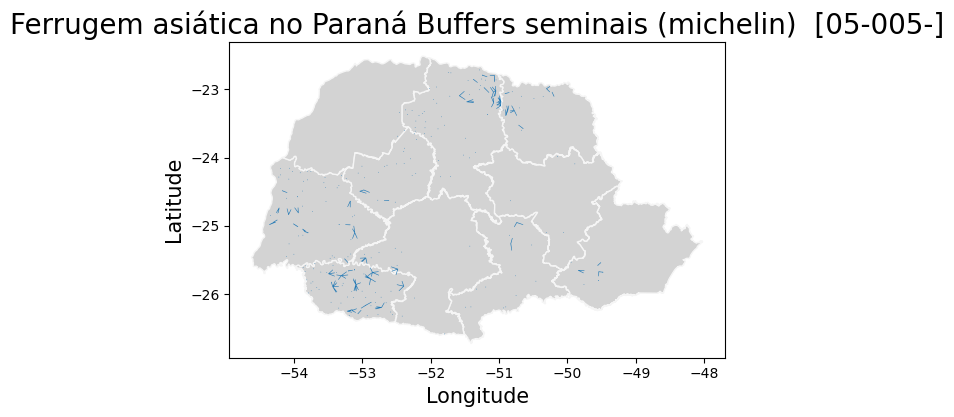

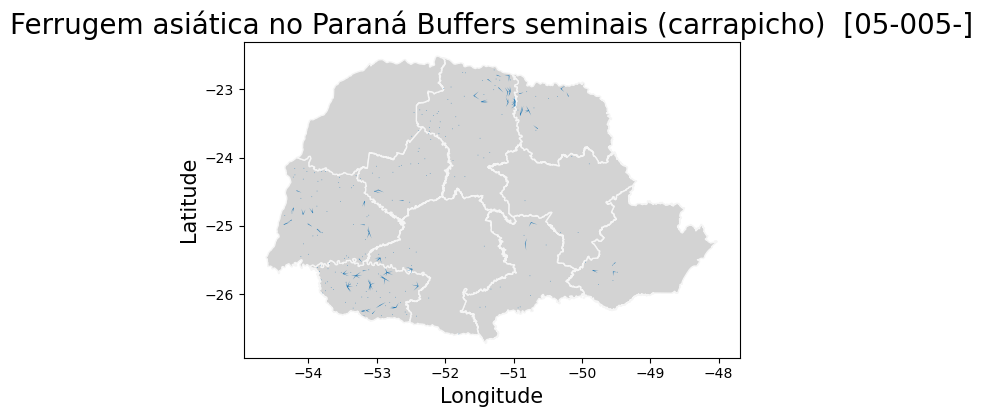

In [12]:
baseDir=os.path.join("C:\\","Users","evand","git","movimentacao-esporos","dados")
(bufs_gs,mapa_base) =  processaColetores(baseDir, 0.05,0.5,"05-005-")


# RASCUNHO

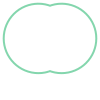

In [13]:
   
a = Point(1, 1).buffer(1.5)
b = Point(2, 1).buffer(1.5)
c = a.union(b)
c.boundary

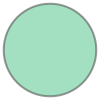

In [14]:
vs = [10,20,30]
idx = ["a","b","c"]
a = Point(1, 1).buffer(1.5)
b = Point(2, 1).buffer(1.5)
c = Point(3, 1).buffer(1.5)
ps = [a,b,c]
gs = GeoSeries(ps, index=idx)
gs["a"]



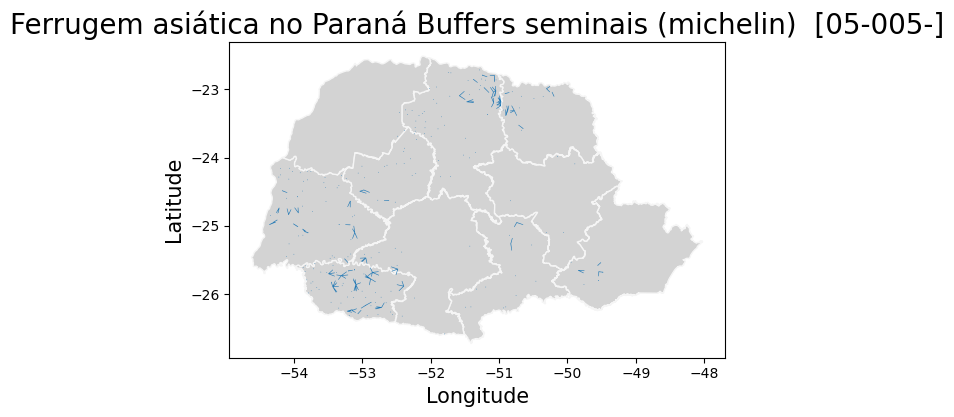

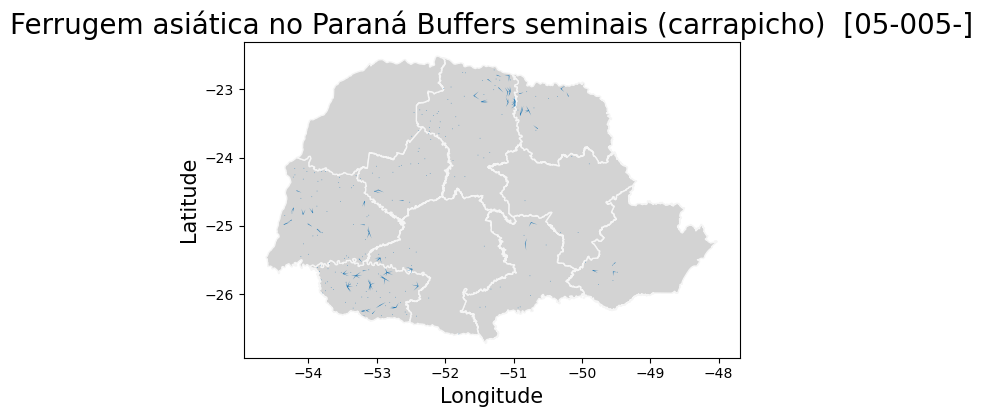

In [15]:
mapasDir='C:\\Users\\evand\\git\\movimentacao-esporos\\dados\\divisas_PR_shapefiles\\pr'
dataDir= "C:\\Users\\evand\\git\\movimentacao-esporos\\dados\\safra2122"
mapaBasePath=os.path.join(mapasDir,'41MEE250GC_SIR.shp')
coletoresfn = os.path.join(dataDir,"ColetoresSafra2122Final.csv")
(bufs_gs,mapa_base) = main(mapaBasePath,coletoresfn,0.5,0.05,"05-005-")

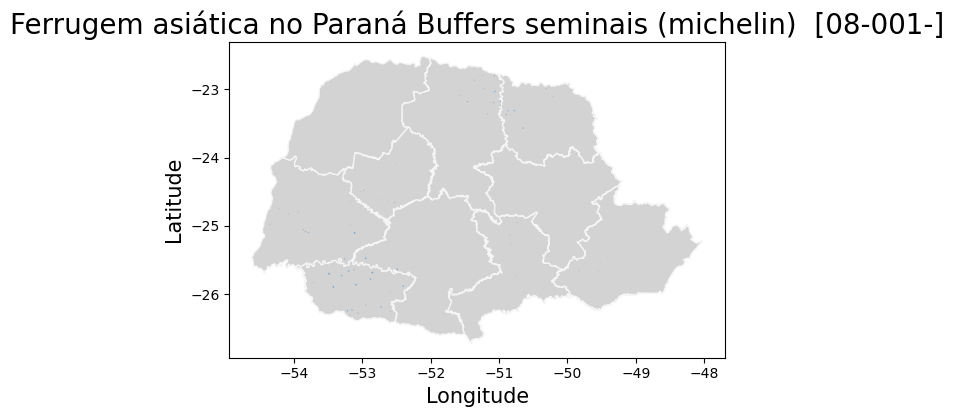

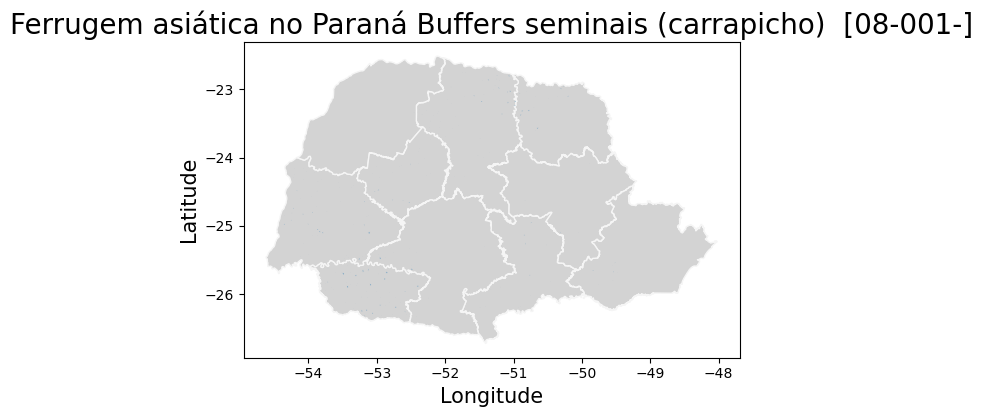

In [16]:
mapasDir='C:\\Users\\evand\\git\\movimentacao-esporos\\dados\\divisas_PR_shapefiles\\pr'
dataDir= "C:\\Users\\evand\\git\\movimentacao-esporos\\dados\\safra2122"
mapaBasePath=os.path.join(mapasDir,'41MEE250GC_SIR.shp')
coletoresfn = os.path.join(dataDir,"ColetoresSafra2122Final.csv")
(bufs_gs,mapa_base) = main(mapaBasePath,coletoresfn,0.8,0.01,"08-001-")

In [ ]:
mapasDir='C:\\Users\\evand\\git\\movimentacao-esporos\\dados\\divisas_PR_shapefiles\\pr'
dataDir= "C:\\Users\\evand\\git\\movimentacao-esporos\\dados\\safra2122"
mapaBasePath=os.path.join(mapasDir,'41MEE250GC_SIR.shp')
coletoresfn = os.path.join(dataDir,"ColetoresSafra2122Final.csv")
(bufs_gs,mapa_base) = main(mapaBasePath,coletoresfn,0.9,0.09,"09-009-")

In [ ]:
mapasDir='C:\\Users\\evand\\git\\movimentacao-esporos\\dados\\divisas_PR_shapefiles\\pr'
dataDir= "C:\\Users\\evand\\git\\movimentacao-esporos\\dados\\safra2122"
mapaBasePath=os.path.join(mapasDir,'41MEE250GC_SIR.shp')
coletoresfn = os.path.join(dataDir,"ColetoresSafra2122Final.csv")
(bufs_gs,mapa_base) = main(mapaBasePath,coletoresfn,1.5,0.05,"15-005-")

In [ ]:
bufs_gs[24].boundary

In [ ]:
dataDir= "C:\\Users\\evand\\git\\movimentacao-esporos\\dados\\safra2122"
coletoresfn = os.path.join(dataDir,"ColetoresSafra2122Final.csv")
df = df = pd.read_csv(coletoresfn, sep=';', decimal=',', parse_dates=['Data'], infer_datetime_format=True).sort_values(by='Data')
#gdf = preparaDadosIniciais(coletoresfn)
df.head()

In [ ]:
rpc = 500
rai = 25
p = Point(10.0, 10.0)
p1 = Point(10.0, 50.0)
p11 = Point(10.0, 500.0)
p2 = Point(30.0, 30.0)
p22 = Point(600.0, 600.0)
p3 = Point(50.0, 10.0)
p33 = Point(600.0, 10.0)
gg = GrowthGeometry(p, rai)
gg.addSegment(p1,p11)
gg.addSegment(p2,p22)
gg.addSegment(p3,p33)

print("carrapicho 1 e boneco 1\n")
carrapicho1 =  criaCarrapicho(gg, 0.6)
boneco1 = criaBonecoMichelin(gg, gg.r, gg.r/2)

print("Cresce e cria carrapicho 2 e boneco 2\n")
gg.growGeometry(1.20)
carrapicho2 = criaCarrapicho(gg, 0.6)
boneco2 = criaBonecoMichelin(gg, gg.r, gg.r/2)

print("Cresce e cria carrapicho 3 e boneco 3\n")
gg.growGeometry(1.20)
carrapicho3 = criaCarrapicho(gg, 0.6)
boneco3 = criaBonecoMichelin(gg, gg.r, gg.r/2)
boneco33 = criaBonecoMichelin(gg, gg.r/2, gg.r)


In [ ]:
carrapicho1

In [ ]:
carrapicho2

In [ ]:
carrapicho3

In [ ]:
boneco1

In [ ]:
boneco2

In [ ]:
boneco3

In [ ]:
boneco33